
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

Cell 1:

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

Cell 2:

# ***What?*** 
<200 words

Cell 3:

## ***Why?***
<200 words

Cell 4:

## ***How?***
<400 words

Cell 5:

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

Cell 6:

## ***Which (words)?***
<300 words

What: For our final project, Sabina, Partha and I are planning to analyze Tweets to predict their behavioral traits.
We will be analyzing behaviour by using a Jungian personality archetype framework - in which
personality can be classified into 16 types. The profile data we are collecting consists of
a person’s "likes", own tweets and retweets, and the list of followers. Crucially, the profiles
that we scraped are self-tagged by personality (ie they declare their type), which is one
of 16 possible. This provides us the labels needed for a classifier.


Why: Jungian personality archetypes are enormously popular in popular culture as many see them as accurate
in their analysis. The trait framework is similar to that of the Big-5 and can be used for
predictive analysis of behavior (t is also highly popular in organizational psychology/industry).
As this conception of personality type is regarded as 'innate' by theorists, this online-profile based
methodology to predict type would serve as a useful theoretical construct to understand social behaviour and
causality in online social networks.


How: Our sample is profile data from Twitter which includes a person's "likes",
tweets and followers. Personality traits would theoretically heavily influence a person's
interests, information consumption patterns, and choice of social sphere in which they participate in.
These factors would at least be partially captures by the kind of tweets people consume (and hence like),
the kind of people they follow (the social game they participate in), and the kind of tweets they write.
These should help us classify people's personalities. The primary limitations arise from the data
being biased by the choice of social platform (as the choice of platform is linked with the social
game being played). The alternative would be to include profiles from other websites as well (Reddit).
Collecting more samples from a variety of different websites would be the best way to scale up the
sample for further analysis.

We are planning to look at a dataset of around 1600 users and their liked tweets. Since actual tweets would likely return a bias toward Extroverted types (more likely to tweet / use unique (and/or) controversial language and topics) we decided to look at liked tweets as a metric of the users personal interests (we would argue this is far less performative than the user-created tweets). Overall, this is a study which intersects social media platform usage and human interaction. The limitations are big: we only have access to what is published on twitter (public accounts which decide to include their personality types and those accounts' likes from other public accounts) and we assume here that people are trustworthy in their personality-type self-reports. Alternatively, platforms like Facebook could be interesting but they, more often than twitter include a more personal network - introducing other limitations and biases. We could scale up the sample by collecting additional information on the users: potentially their own Tweets, other twitter metrics, or even an attempt to combine their profile information with other personal info (scraped from FB or so)...


# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [6]:
newsgroupsCategories = ['soc.religion.christian', 'rec.sport.baseball', 'sci.med', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: soc.religion.christian
Fetching data for: rec.sport.baseball
Fetching data for: sci.med
Fetching data for: rec.autos
2384


,text,category,source_file
0,I wrote in response to dlecoint@garnet.acns.fs...,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...
1,"A ""new Christian"" wrote that he was new to the...",soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...
2,: > \t I'm a commited Christian that is batt...,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...
3,My brother has been alienated from my parents ...,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...
4,"> [A very nice article on the DSS, which I ...",soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...
5,\nA question for you - can you give me the nam...,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...
6,Why is it that we have this notion that God ta...,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...
7,"\n\n\nMust there be a ""why"" to this? I ask be...",soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...
8,\n ^^^^^^^^^^^^^^^^^...,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...
9,\n\nTerms are being used in a loaded way here....,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [7]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2384, 26624)


I'm pretty sure that you're very familiar with the cell above now, but let's go through the concepts again. 

What do we want to do here? We want to do vectorization, i.e., converting texts into numerical features (vectors) as required by machine learning algorithms. And this is what feature_extraction module does: to extract features from texts in a format as required by ML algorithms. feature_extraction module has four classes: CountVectorizer, DictVectorizer, TfidfVectorizer, and FeatureHasher. Here, we use CountVectorizer, but we'll also use TfidfVectorizer as well below.

There are various strategies by which we extract features. Here, we use CountVectorizer, and, in particular, we use 'Bag of Words' representation. In other words, the features we hope to extract from the texts are each individual token occurrence frequency. We simply count the the occurrence of each token in each document. So, here, we get a document-term-matrix, in which documents are characterized by the occurrences of tokens. Other forms of features, such as the relative position information of words, are ignored. We'll see other types of representations and strategies as well soon, such as N-gram (by the way, we can do n-gram with CountVectorizer. CountVectorizer class takes a set of parameters, such as analyzer, which you can specify the n-gram). 

the first line of the cell above instantiate a class, CountVectorizer(). In other words, you created an instance, or realization of a class. What is a class and what does instantiation mean? That's a long story, maybe for next time.

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [9]:
newsgroupsVects

<2384x26624 sparse matrix of type '<class 'numpy.int64'>'
	with 226143 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [13]:
newsgroupsVects[90:100,100:110].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

What is the toarray() function here? It's similar to todense()--todense() and toarray() both returns a dense representation of a matrix; however, todense() returns a matrix representation while toarray() returns a ndarray representation.

We can also lookup the indices of different words using the Vectorizer

In [24]:
ngCountVectorizer.vocabulary_.get('football')

10311

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [27]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape) #number of documents by number of words

(2384, 26624)


This gives us the tf-idf for each word in each text

In [28]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('wrote', 0.014742176700608942),
 ('in', 0.017682642448812645),
 ('response', 0.016140534653556585),
 ('to', 0.028821759779681527),
 ('dlecoint', 0.012536976902650562),
 ('garnet', 0.015957275239513895),
 ('acns', 0.017102599030211857),
 ('fsu', 0.007005124305234519),
 ('edu', 0.018555744285863998),
 ('darius_lecointe', 0.017102599030211857),
 ('was', 0.012003564217500984),
 ('paul', 0.027807201568315894),
 ('god', 0.06499037237354242),
 ('too', 0.07604481476323519),
 ('is', 0.009601725629618495),
 ('an', 0.015674294966790243),
 ('interpretation', 0.013826936091054084),
 ('of', 0.05212974258278022),
 ('the', 0.02147005777314559),
 ('words', 0.016316593440319885)]

Let's see what we're doing here. First, you need to know what vocabulary\_ does. vocabulary\_ is an attribute of the CountVectorizer, which gives you a mapping of terms to feature indices. It gives you all the terms and their feature indices, so it's a dictionary. So, by doing "ngCountVectorizer.vocabulary\_.keys()", we get the keys of the dictionary, which are the terms. 

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [29]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [31]:
newsgroupsTFVects

<2384x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 65288 stored elements in Compressed Sparse Row format>

In [30]:
newsgroupsDF['text']

0       I wrote in response to dlecoint@garnet.acns.fs...
1       A "new Christian" wrote that he was new to the...
2       : > \t   I'm a commited Christian that is batt...
3       My brother has been alienated from my parents ...
4          > [A very nice article on the DSS, which I ...
                              ...                        
2379    I was wondering if anyone out in net-land have...
2380    \n\n\n\n\nI sold my '86 Sprint last April with...
2381    Actually I wasn't too surprised, since I bough...
2382    \n\nI couldnt agree more.  That is how it SHOU...
2383    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2384, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [39]:
try:
    print(ngTFVectorizer.vocabulary_['drug'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

303


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [40]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [43]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [44]:
km.fit(newsgroupsTFVects)

KMeans(n_clusters=4)

In [48]:
km.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 4,
 'n_init': 10,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [51]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))
#print("f1: {:0.3f}".format(sklearn.metrics.f1_score(newsgroupsDF['category'], km.labels_))) 
#f1 is useful for test data

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', 'mean_tweedie_deviance', 'median_absolute_error', 'mult

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [52]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,I wrote in response to dlecoint@garnet.acns.fs...,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...,2
1,"A ""new Christian"" wrote that he was new to the...",soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...,2
2,: > \t I'm a commited Christian that is batt...,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...,2
3,My brother has been alienated from my parents ...,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...,3
4,"> [A very nice article on the DSS, which I ...",soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...,3
...,...,...,...,...
2379,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3
2380,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1
2381,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1
2382,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3


We can also look at the distinguishing features in each cluster:

In [53]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 cadre
 dsl
 n3jxp
 chastity
 shameful
 surrender
 intellect
 geb
 skepticism
 pitt


Cluster 1:
 car
 cars
 engine
 like
 dealer
 just
 price
 speed
 good
 new


Cluster 2:
 god
 jesus
 people
 church
 christ
 faith
 christians
 believe
 bible
 christian


Cluster 3:
 like
 just
 know
 don
 think
 year
 good
 time
 people
 does




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [54]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [55]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [60]:
colordict = {
'soc.religion.christian': 'red',
'rec.sport.baseball': 'orange',
'sci.med': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('soc.religion.christian', 'red'), ('rec.sport.baseball', 'orange'), ('sci.med', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

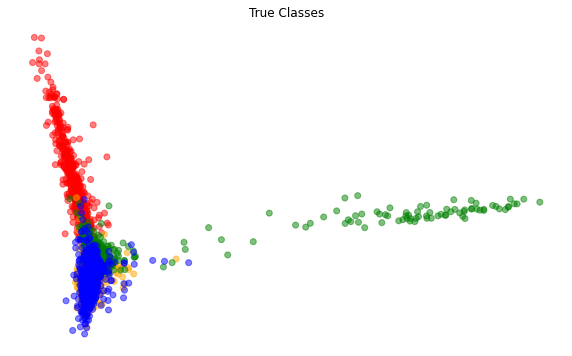

In [57]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

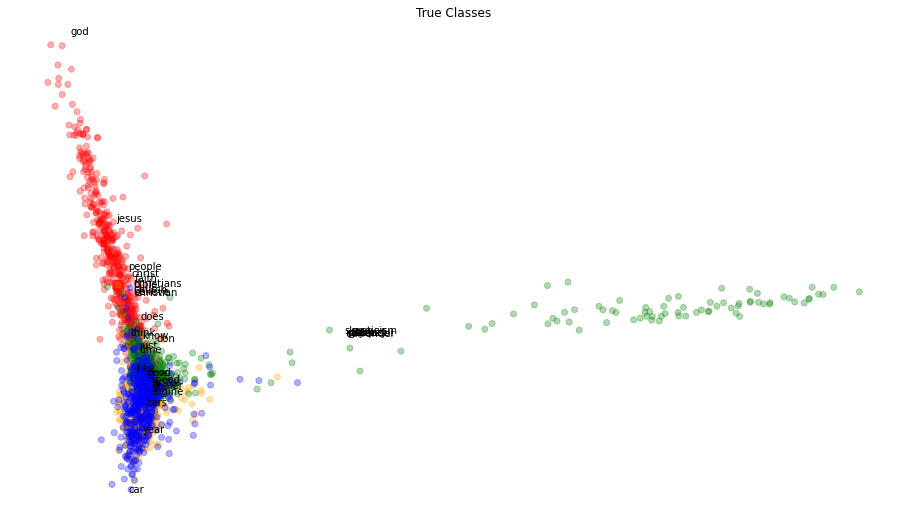

In [63]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [64]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

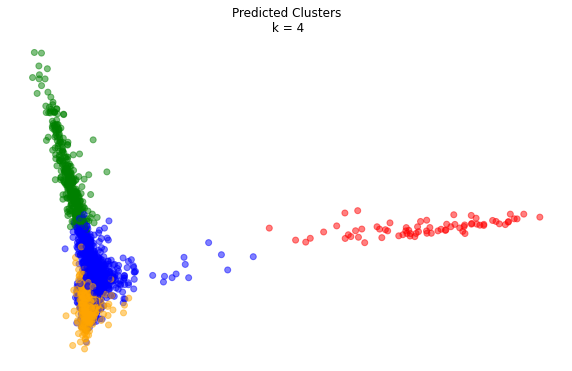

In [65]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [66]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(n_clusters=3)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [67]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


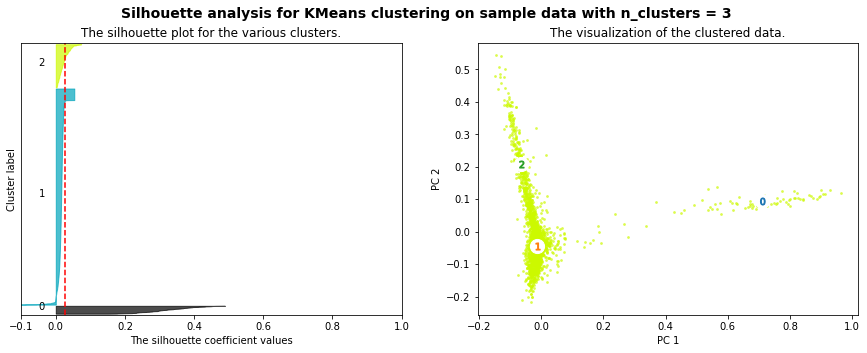

For n_clusters = 3, The average silhouette_score is : 0.026


In [73]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


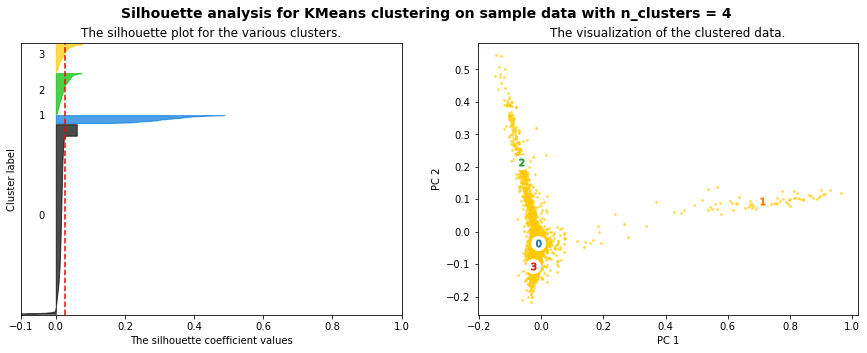

For n_clusters = 4, The average silhouette_score is : 0.026


In [69]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


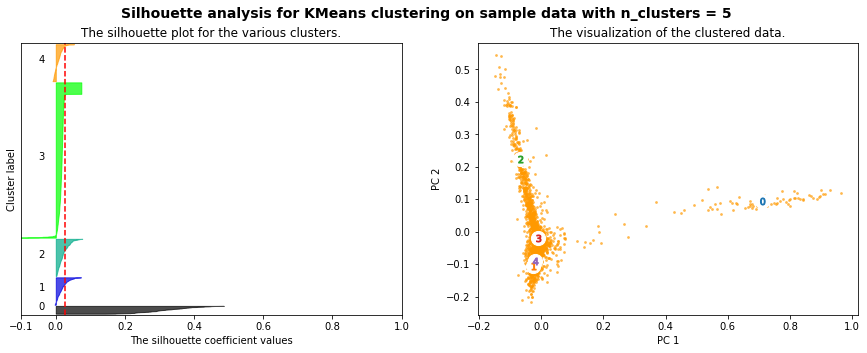

For n_clusters = 5, The average silhouette_score is : 0.026


In [70]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


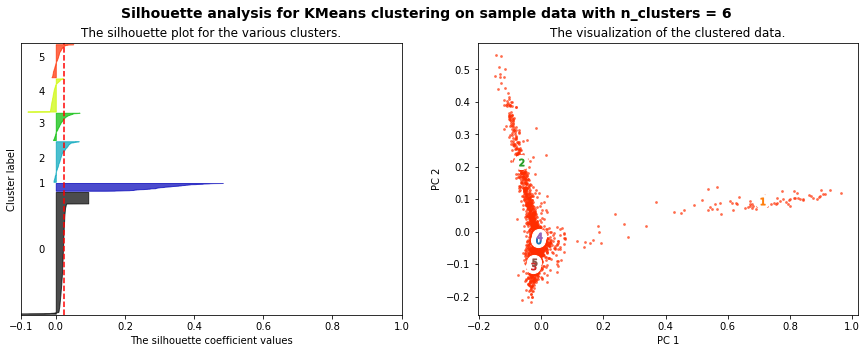

For n_clusters = 6, The average silhouette_score is : 0.024


In [71]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [ ]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']

#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
#senReleasesTraining.to_csv("data/senReleasesTraining.csv")


#senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

In [76]:
senReleasesTraining

,name,text,path,html_url,download_url,targetSenator
0,01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Apr2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy
1,01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Aug2005Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy
2,01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy10.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy
3,01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy11.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy
4,01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy
...,...,...,...,...,...,...
995,18Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Department ...,raw/Kennedy/18Jul2005Kennedy13.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy
996,18Jul2005Kennedy14.txt,FOR IMMEDIATE RELEASE I welcome t...,raw/Kennedy/18Jul2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy
997,18Jul2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/18Jul2006Kennedy0.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy
998,18Jul2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/18Jul2006Kennedy1.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [77]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [79]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senate', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [80]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [81]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [82]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(n_clusters=3)

And visualize:

In [84]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

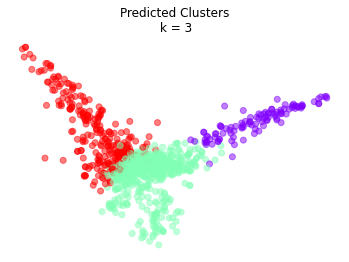

In [85]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [86]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,name,text,path,html_url,download_url,targetSenator,kmeans_predictions
0,01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Apr2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2
1,01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Aug2005Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1
2,01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy10.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2
3,01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy11.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1
4,01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1
...,...,...,...,...,...,...,...
995,18Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Department ...,raw/Kennedy/18Jul2005Kennedy13.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2
996,18Jul2005Kennedy14.txt,FOR IMMEDIATE RELEASE I welcome t...,raw/Kennedy/18Jul2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1
997,18Jul2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/18Jul2006Kennedy0.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1
998,18Jul2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/18Jul2006Kennedy1.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [ ]:
#!pip3 install tweet-preprocessor 
#additional package to clean tweets

In [145]:
import preprocessor as pre
import os
import pandas as pd


In [140]:
dfs = []
i = 0
for file in os.listdir("data/"):
    print(file, i)
    if 'json' in file:
        dfs.append(pd.read_json('data/' + file).transpose())
        dfs[i]['Category'] = file[:4]
        i += 1

ESFJ.json 0
ISFP.json 1
INFJ.json 2
ENFP.json 3
.DS_Store 4
INTP.json 4
ENTJ.json 5
ESTP.json 6
ISTJ.json 7
ENTP.json 8
INTJ.json 9
ISTP.json 10
ESTJ.json 11
ESFP.json 12
ENFJ.json 13
INFP.json 14


In [141]:
small_dfs = [df.sample(frac=0.01) for df in dfs]
all_small = pd.concat(small_dfs)

In [146]:
all_small['text'] = [pre.clean(t) for t in all_small['text']]

In [147]:
all_small = all_small.loc[:, ['Category', 'text']]

In [148]:
all_small.reset_index(drop=True, inplace=True)

In [149]:
#First it needs to be initialized
twCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
tweetVects = twCountVectorizer.fit_transform(all_small['text'])
print(tweetVects.shape)

(3750, 11463)


In [150]:
twCountVectorizer.vocabulary_

{'yes': 11390,
 'it': 5227,
 'came': 1497,
 'out': 7257,
 'at': 679,
 'the': 10189,
 'beginning': 977,
 'of': 7095,
 'december': 2535,
 'on': 7145,
 'amazon': 392,
 'prime': 7943,
 'day': 2496,
 'song': 9484,
 'to': 10331,
 'listen': 5889,
 'while': 11172,
 'studying': 9797,
 'prismidk': 7961,
 'why': 11192,
 'but': 1438,
 'like': 5856,
 'prism': 7960,
 'when': 11161,
 'working': 11294,
 'autocad': 740,
 'for': 3873,
 'uni': 10693,
 'projects': 8017,
 'keeps': 5490,
 'me': 6286,
 'company': 2018,
 'without': 11253,
 'getting': 4138,
 'distracted': 2866,
 'dont': 2959,
 'watch': 11080,
 'this': 10237,
 'perf': 7547,
 'tho': 10240,
 'cause': 1611,
 'that': 10185,
 'would': 11315,
 'get': 4135,
 'hate': 4486,
 'texting': 10169,
 'can': 1505,
 'we': 11094,
 'just': 5417,
 'merge': 6398,
 'into': 5148,
 'one': 7149,
 'soul': 9508,
 'and': 432,
 'he': 4508,
 'apologized': 524,
 'trump': 10519,
 'took': 10371,
 'full': 3998,
 'page': 7335,
 'ad': 189,
 'call': 1486,
 'death': 2520,
 'penalty'

In [151]:
twTFtransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(tweetVects)

In [152]:
tweetTF = twTFtransformer.transform(tweetVects)

In [153]:
tweetTF.shape

(3750, 11463)

In [154]:
list(zip(twCountVectorizer.vocabulary_.keys(), tweetTF.data))[:20]

[('yes', 0.29913307730549527),
 ('it', 0.11062814694274682),
 ('came', 0.39786857468252323),
 ('out', 0.22640503555198244),
 ('at', 0.17125205764913337),
 ('the', 0.1369524489908953),
 ('beginning', 0.15776599799344654),
 ('of', 0.3896228687762758),
 ('december', 0.3283683597750357),
 ('on', 0.39786857468252323),
 ('amazon', 0.1987919934288598),
 ('prime', 0.39786857468252323),
 ('day', 0.11577222492316429),
 ('song', 0.13990867351105474),
 ('to', 0.14428510234125866),
 ('listen', 0.12134909900110659),
 ('while', 0.1324104621010386),
 ('studying', 0.10002864666330732),
 ('prismidk', 0.13423442038570368),
 ('why', 0.1882742086909216)]

In [155]:
#initialize
twTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
twTFVects = twTFVectorizer.fit_transform(all_small['text'])

In [156]:
twTFVects

<3750x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 15477 stored elements in Compressed Sparse Row format>

In [157]:
numClusters = len(set(all_small['Category']))
numClusters #number of distinct personality types

15

In [158]:
km1 = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

In [159]:
km1.fit(twTFVects)

KMeans(n_clusters=15)

In [160]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(all_small['Category'], km1.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(all_small['Category'], km1.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(all_small['Category'], km1.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(all_small['Category'], km1.labels_)))
#print("f1: {:0.3f}".format(sklearn.metrics.f1_score(newsgroupsDF['category'], km.labels_))) 
#f1 is useful for test data

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', 'mean_tweedie_deviance', 'median_absolute_error', 'mult

In [161]:
def assign_roles(row):
    if row['Category'] in ['INTJ', 'INTP', 'ENTJ', 'ENTP']:
        return 'analyst'
    elif row['Category'] in ['INFJ', 'INFP', 'ENFJ', 'ENFP']:
        return 'diplomat'
    elif row['Category'] in ['ISTJ', 'ISFJ', 'ESTJ', 'ESFJ']:
        return 'sentinels'
    else:
        return 'explorers'
all_small['roles'] = all_small.apply(lambda x: assign_roles(x), axis=1)

In [162]:
km = sklearn.cluster.KMeans(n_clusters=4, init='k-means++')
km.fit(twTFVects)

KMeans(n_clusters=4)

In [163]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(all_small['roles'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(all_small['roles'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(all_small['roles'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(all_small['roles'], km.labels_)))
#print("f1: {:0.3f}".format(sklearn.metrics.f1_score(newsgroupsDF['category'], km.labels_))) 
#f1 is useful for test data

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', 'mean_tweedie_deviance', 'median_absolute_error', 'mult

In [164]:
all_small['kmeans_predictions'] = km1.labels_
all_small['kmeans_predictions_roles'] = km.labels_
all_small

,Category,text,roles,kmeans_predictions,kmeans_predictions_roles
0,ESFJ,Yes it came out at the beginning of December o...,sentinels,1,1
1,ESFJ,day ~ song to listen to while studying ~ Prism...,sentinels,1,1
2,ESFJ,I hate texting can we just merge into one soul,sentinels,1,3
3,ESFJ,"Yes, and he apologized. Trump took out a full ...",sentinels,1,1
4,ESFJ,Herbert the vacuum seems a little dramatic,sentinels,1,1
...,...,...,...,...,...
3745,INFP,A once in a lifetime chance and all I wanna do...,diplomat,1,1
3746,INFP,"When I'm having a good day, but have been cond...",diplomat,1,1
3747,INFP,I was never mad tbh,diplomat,1,1
3748,INFP,Please pray for my mom. Covid is not doing us ...,diplomat,1,3


In [165]:
terms = twTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(4):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 thank
 amp
 new
 day
 happy
 year
 birthday
 great
 like
 years


Cluster 1:
 like
 im
 people
 good
 know
 time
 need
 think
 going
 work


Cluster 2:
 today
 years
 day
 ago
 know
 ve
 stream
 just
 president
 thank


Cluster 3:
 just
 love
 like
 people
 know
 time
 say
 really
 want
 did




In [166]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(twTFVects.toarray())
reduced_data = pca.transform(twTFVects.toarray())

In [167]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [168]:
colordict = {
'sentinels': 'red',
'diplomat': 'orange',
'analyst': 'green',
'explorers': 'blue',
    }
colors = [colordict[c] for c in all_small['roles']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('sentinels', 'red'), ('diplomat', 'orange'), ('analyst', 'green'), ('explorers', 'blue')])


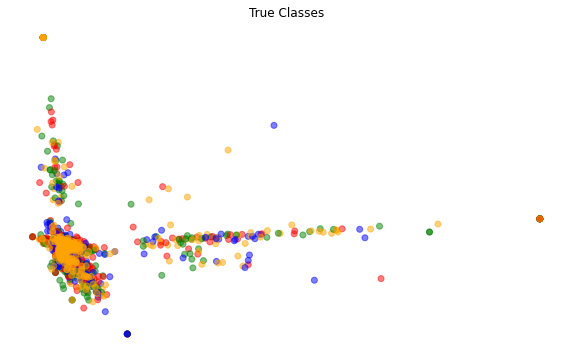

In [169]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

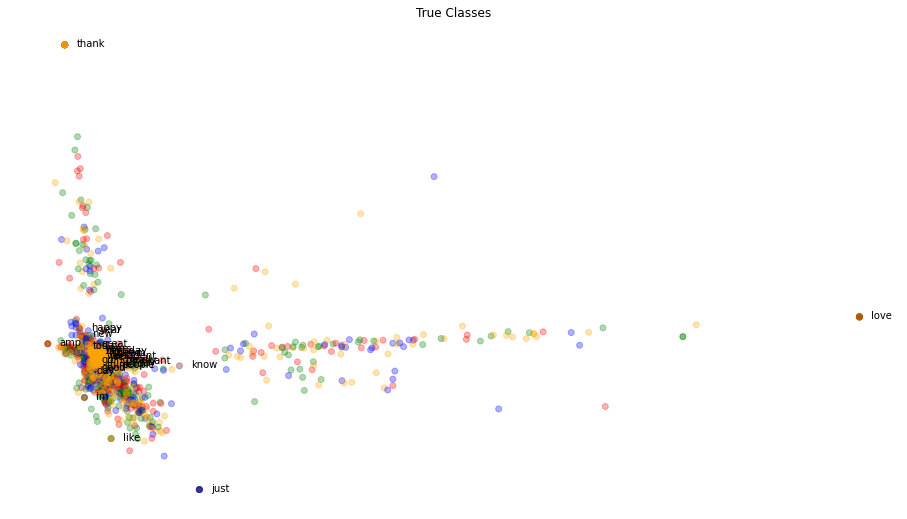

In [170]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [171]:
colors_p = [list(colordict.values())[l] for l in km.labels_]

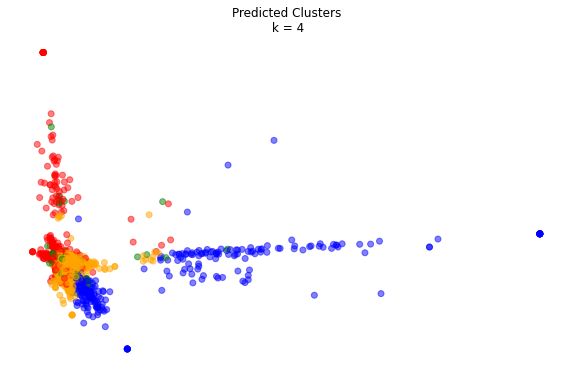

In [172]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


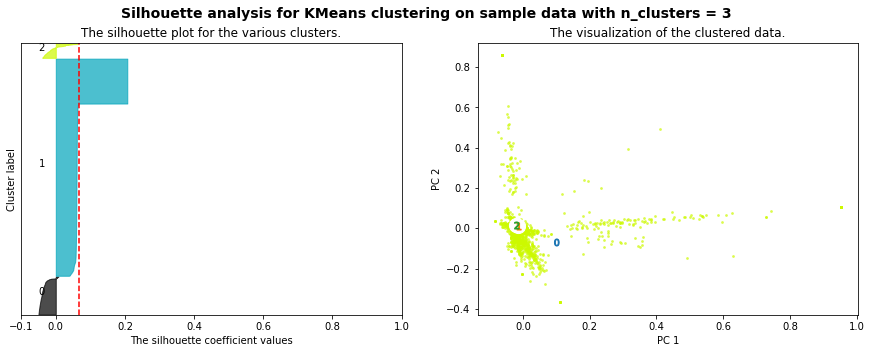

For n_clusters = 3, The average silhouette_score is : 0.067


In [173]:
X = twTFVects.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


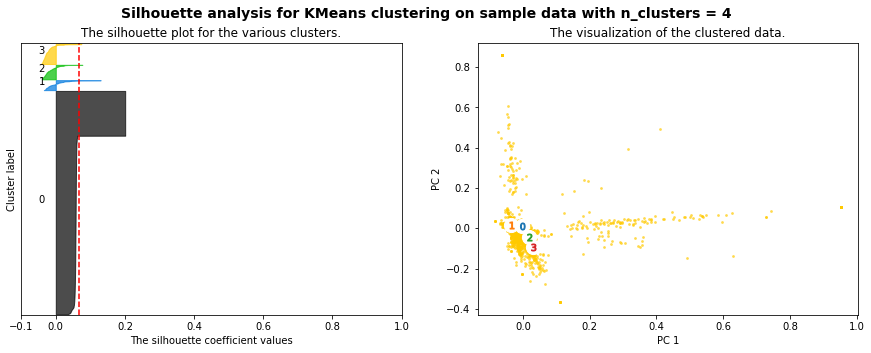

For n_clusters = 4, The average silhouette_score is : 0.068


In [174]:
X = twTFVects.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


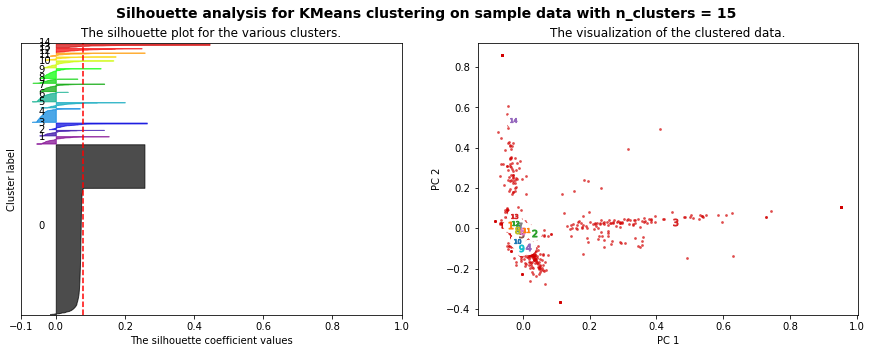

For n_clusters = 15, The average silhouette_score is : 0.079


In [176]:
X = twTFVects.toarray()
plotSilhouette(15, X)

Optimal number of clusters seem to be 15 -- the number of personality types in the corpus. But overall the k-means clustering method fails to capture the subtleties between each Myer-Briggs personality role. The groups arising from unsupervised clustering and predefined classes are not similar to each other. 

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [87]:
newsgroupsTFVects

<2384x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 65288 stored elements in Compressed Sparse Row format>

In [88]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.01817483, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.13002485, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [89]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [90]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [91]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [92]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 43.        ,  45.        ,   0.        ,   2.        ],
       [ 48.        , 200.        ,   0.        ,   3.        ],
       [ 84.        , 201.        ,   0.        ,   4.        ],
       [ 98.        , 202.        ,   0.        ,   5.        ],
       [168.        , 203.        ,   0.        ,   6.        ],
       [190.        , 204.        ,   0.        ,   7.        ],
       [ 72.        , 179.        ,   0.35340871,   2.        ],
       [205.        , 206.        ,   0.40255088,   9.        ],
       [140.        , 164.        ,   0.4191561 ,   2.        ],
       [  6.        , 207.        ,   0.4216335 ,  10.        ]])

Now we can visualize the tree

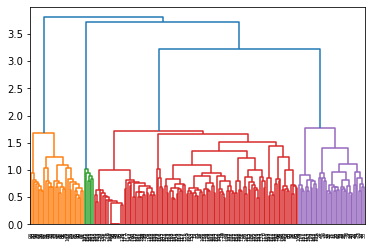

In [93]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

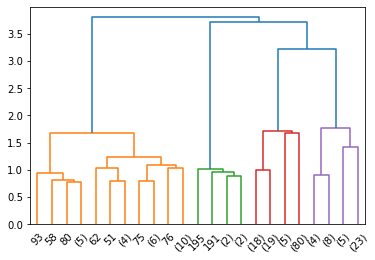

In [94]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [95]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 3, 4, 4, 4, 3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4,
       4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 4, 4, 4, 3,
       4, 3, 3, 4, 3, 4, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3,
       1, 1, 1, 3, 3, 3, 3, 1, 4, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3,
       3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4,
       3, 3, 4, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3,
       3, 3], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [96]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.265
Completeness: 0.358
V-measure: 0.305
Adjusted Rand Score: 0.176


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [97]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,kmeans_predictions,wald_predictions
0,I wrote in response to dlecoint@garnet.acns.fs...,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...,2,2
1,"A ""new Christian"" wrote that he was new to the...",soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...,2,2
2,: > \t I'm a commited Christian that is batt...,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...,2,2
3,My brother has been alienated from my parents ...,soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...,3,2
4,"> [A very nice article on the DSS, which I ...",soc.religion.christian,../data/scikit_learn_data/20news_home/20news-b...,3,2
...,...,...,...,...,...
2379,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3,3
2380,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1,3
2381,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,1,4
2382,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3,2


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [98]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

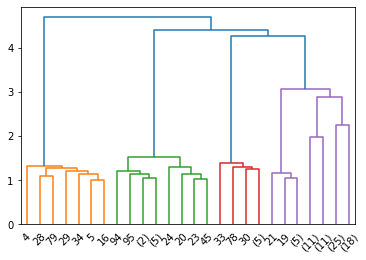

In [99]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [100]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [177]:
twCoocMat = twTFVects * twTFVects.T
twCoocMat.setdiag(0)

/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [178]:
selectIndices = []
indexToCat = []
for c in set(all_small['roles']):
    selectIndices += list(all_small[all_small['roles'] == c].index)[:100]
    indexToCat += [c] * 50

In [179]:
subCoocMat = twCoocMat[selectIndices,:][:,selectIndices]

In [180]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[  2.,   3.,   0.,   2.],
       [  4., 400.,   0.,   3.],
       [ 15., 401.,   0.,   4.],
       [ 16., 402.,   0.,   5.],
       [ 18., 403.,   0.,   6.],
       [ 19., 404.,   0.,   7.],
       [ 21., 405.,   0.,   8.],
       [ 27., 406.,   0.,   9.],
       [ 29., 407.,   0.,  10.],
       [ 30., 408.,   0.,  11.]])

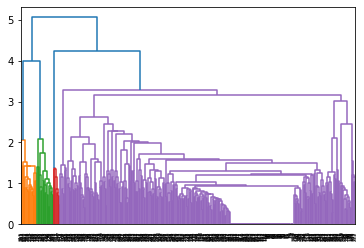

In [181]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

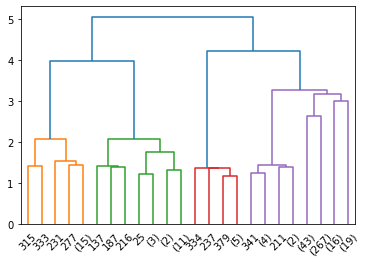

In [182]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

In [183]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 1, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4,
       4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4,
       4, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 2, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 1, 4, 4, 1, 4, 1, 4, 4, 2, 2, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4,
       4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4,

In [184]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(twCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(all_small['roles'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(all_small['roles'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(all_small['roles'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(all_small['roles'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.002
Completeness: 0.004
V-measure: 0.002
Adjusted Rand Score: -0.001


In [185]:
all_small['wald_predictions'] = hierarchicalClusters_full
all_small

,Category,text,roles,kmeans_predictions,kmeans_predictions_roles,wald_predictions
0,ESFJ,Yes it came out at the beginning of December o...,sentinels,1,1,4
1,ESFJ,day ~ song to listen to while studying ~ Prism...,sentinels,1,1,4
2,ESFJ,I hate texting can we just merge into one soul,sentinels,1,3,3
3,ESFJ,"Yes, and he apologized. Trump took out a full ...",sentinels,1,1,4
4,ESFJ,Herbert the vacuum seems a little dramatic,sentinels,1,1,4
...,...,...,...,...,...,...
3745,INFP,A once in a lifetime chance and all I wanna do...,diplomat,1,1,4
3746,INFP,"When I'm having a good day, but have been cond...",diplomat,1,1,4
3747,INFP,I was never mad tbh,diplomat,1,1,4
3748,INFP,Please pray for my mom. Covid is not doing us ...,diplomat,1,3,3


Based on metrics of homogeneity, completeness, v-measure, and adjusted rand score, the hierarchical clustering did worse than the flat clustering via k-means clustering, however, it is fair to say that both methods performed worse and probably there are no underlying pattern that hints the personality roles in the corpus. 

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [102]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [103]:
senReleasesTraining[::100]

,name,text,path,html_url,download_url,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Apr2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,02Feb2006Kennedy7.txt,FOR IMMEDIATE RELEASE Lithonia Geor...,raw/Kennedy/02Feb2006Kennedy7.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Lithonia, GeorgiaTod...","[immediate, release, lithonia, georgiatoday, s..."
200,04May2005Kennedy7.txt,FOR IMMEDIATE RELEASE Washington ...,raw/Kennedy/04May2005Kennedy7.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, Ye...","[immediate, release, washington, have, c, yest..."
300,06Jun2006Kennedy4.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/06Jun2006Kennedy4.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, pdf, ..."
400,08Dec2006Kennedy3.txt,FOR IMMEDIATE RELEASE Washington D ...,raw/Kennedy/08Dec2006Kennedy3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,09May2007Kennedy6.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,raw/Kennedy/09May2007Kennedy6.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, CToda...","[immediate, release, washington, have, ctoday,..."
600,11May2007Kennedy0.txt,FOR IMMEDIATE RELEASE BOSTON MA Se...,raw/Kennedy/11May2007Kennedy0.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, BOSTON, MA, Senator,...","[immediate, release, boston, ma, senator, edwa..."
700,13Jul2005Kennedy5.txt,FOR IMMEDIATE RELEASE Washington ...,raw/Kennedy/13Jul2005Kennedy5.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
800,15Dec2005Kennedy3.txt,FOR IMMEDIATE RELEASE Washington ...,raw/Kennedy/15Dec2005Kennedy3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,16May2006Kennedy13.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/16May2006Kennedy13.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, amend..."


In [104]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [105]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [106]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [118]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'docbyoffset',
 'index',
 'input',
 'length',
 'load',
 'num_docs',
 'num_nnz',
 'num_terms',
 'save',
 'save_corpus',
 'serialize',
 'skip_headers',
 'transposed']

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [119]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [109]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(2, 0.6039454), (6, 0.3729042)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [110]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [111]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(6, 0.97201747)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.972017,0.000000,0.000000,0.000000
101,02Feb2006Kennedy8.txt,"[(2, 0.9472303)]",0.000000,0.000000,0.947230,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
201,04May2006Kennedy7.txt,"[(0, 0.3207869), (8, 0.40701386), (9, 0.2589961)]",0.320787,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.407014,0.258996
301,06Jun2006Kennedy5.txt,"[(2, 0.5388451), (4, 0.028010657), (6, 0.33676...",0.000000,0.000000,0.538845,0.000000,0.028011,0.0,0.336767,0.094674,0.000000,0.000000
401,08Dec2006Kennedy4.txt,"[(1, 0.044687867), (4, 0.4580282), (6, 0.43465...",0.000000,0.044688,0.000000,0.000000,0.458028,0.0,0.434651,0.000000,0.060628,0.000000
501,09Nov2005Kennedy10.txt,"[(3, 0.99319106)]",0.000000,0.000000,0.000000,0.993191,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
601,11Nov2005Kennedy5.txt,"[(4, 0.97530234)]",0.000000,0.000000,0.000000,0.000000,0.975302,0.0,0.000000,0.000000,0.000000,0.000000
701,13Jun2006Kennedy0.txt,"[(6, 0.9953126)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.995313,0.000000,0.000000,0.000000
801,15Dec2005Kennedy4.txt,"[(9, 0.94679874)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.946799
901,16May2007Kennedy10.txt,"[(0, 0.010491716), (2, 0.03124786), (4, 0.9455...",0.010492,0.000000,0.031248,0.000000,0.945587,0.0,0.000000,0.000000,0.000000,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [126]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFVisNames

array([['01Apr2005Kennedy14.txt'],
       ['01Aug2005Kennedy12.txt'],
       ['01Aug2006Kennedy10.txt'],
       ['01Aug2006Kennedy11.txt'],
       ['01Aug2006Kennedy12.txt'],
       ['01Aug2006Kennedy13.txt'],
       ['01Aug2006Kennedy14.txt'],
       ['01Aug2007Kennedy5.txt'],
       ['01Aug2007Kennedy6.txt'],
       ['01Aug2007Kennedy7.txt']], dtype=object)

First we can visualize as a stacked bar chart:

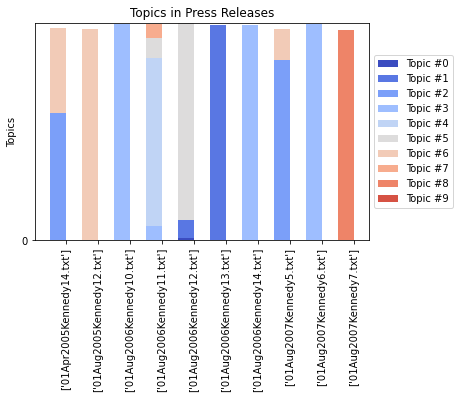

In [125]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

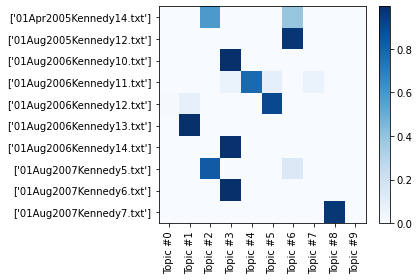

In [127]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [133]:
senlda.show_topic(7)

[('loan', 0.014853173),
 ('lender', 0.008631645),
 ('fund', 0.006652864),
 ('iraqi', 0.003433043),
 ('troop', 0.0033724832),
 ('rate', 0.0031144326),
 ('aid', 0.0030749415),
 ('hear', 0.0029753204),
 ('teacher', 0.002904293),
 ('head', 0.0028827486)]

And if we want to make a dataFrame:

In [134]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fund,worker,fund,immigration,worker,loan,fund,loan,wage,fund
1,worker,pension,head,worker,wage,fund,medicare,lender,worker,worker
2,minimum,fund,worker,immigrant,minimum,lender,mental,fund,minimum,head
3,insurance,company,immigration,unite,association,worker,asbestos,iraqi,woman,asbestos
4,wage,troop,border,troop,mental,rate,coverage,troop,hour,victim
5,fda,loan,teacher,fund,insurance,teacher,senior,rate,fund,company
6,employee,rule,unite,standard,unite,concern,victim,aid,unite,judge
7,science,fail,ireland,company,employee,train,agency,hear,troop,agency
8,pension,lose,immigrant,bankruptcy,employer,follow,judge,teacher,immigration,trust
9,coverage,retirement,pension,agency,judge,aid,concern,head,company,claim


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

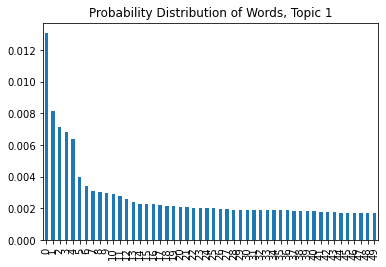

In [135]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [136]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

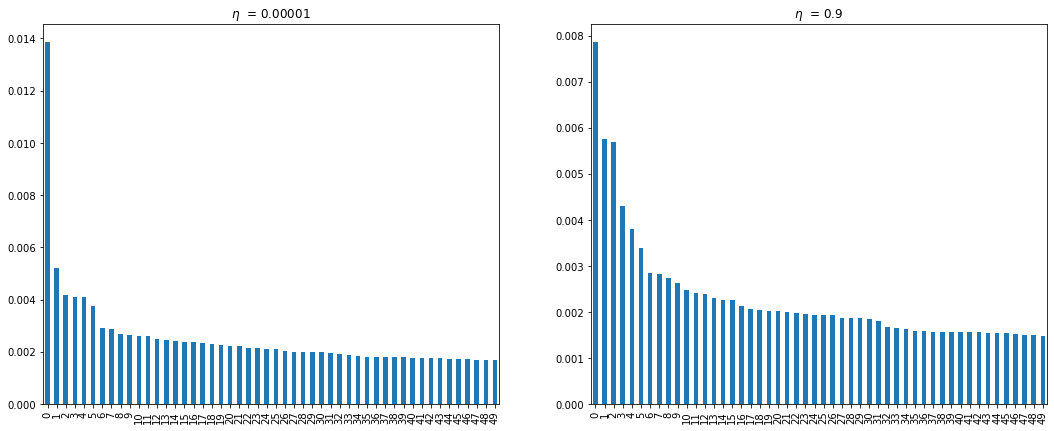

In [137]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [210]:
#Apply our functions
all_small['tokenized_text'] = all_small['text'].apply(lambda x: lucem_illud.word_tokenize(x))
all_small['normalized_tokens'] = all_small['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [211]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

all_small['reduced_tokens'] = all_small['normalized_tokens'].apply(lambda x: dropMissing(x, twTFVectorizer.vocabulary_.keys()))

In [212]:
dictionary = gensim.corpora.Dictionary(all_small['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in all_small['reduced_tokens']]

In [213]:
gensim.corpora.MmCorpus.serialize('tweet.mm', corpus)
twmm = gensim.corpora.MmCorpus('tweet.mm')

In [214]:
twlda = gensim.models.ldamodel.LdaModel(corpus=twmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [215]:
tw1Bow = dictionary.doc2bow(all_small['reduced_tokens'][0])
tw1lda = twlda[tw1Bow]
print(tw1lda)

[(0, 0.022680482), (1, 0.02254266), (2, 0.22304417), (3, 0.5913187), (4, 0.023937814), (5, 0.022970866), (6, 0.023863552), (7, 0.02240581), (8, 0.024364686), (9, 0.02287126)]


In [216]:
ldaDF = pd.DataFrame({
        'role' : all_small['roles'],
        'topics' : [twlda[dictionary.doc2bow(l)] for l in all_small['reduced_tokens']]
    })

In [217]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(twlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(twlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,role,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,sentinels,"[(5, 0.11117301), (6, 0.82256)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.111173,0.822560,0.000000,0.000000,0.000000
101,sentinels,"[(0, 0.046484813), (1, 0.046201073), (2, 0.046...",0.046485,0.046201,0.046826,0.047947,0.049052,0.047077,0.048907,0.570696,0.049934,0.046875
201,sentinels,"[(0, 0.097815335), (1, 0.09721878), (2, 0.0985...",0.097815,0.097219,0.098535,0.100895,0.103219,0.099061,0.102915,0.096630,0.105072,0.098638
301,explorers,"[(0, 0.097815335), (1, 0.09721878), (2, 0.0985...",0.097815,0.097219,0.098535,0.100895,0.103219,0.099061,0.102915,0.096630,0.105072,0.098638
401,explorers,"[(0, 0.097815335), (1, 0.09721878), (2, 0.0985...",0.097815,0.097219,0.098535,0.100895,0.103219,0.099061,0.102915,0.096630,0.105072,0.098638
501,diplomat,"[(0, 0.3336566), (1, 0.030298535), (2, 0.41586...",0.333657,0.030299,0.415864,0.031446,0.032173,0.030873,0.032078,0.030116,0.032752,0.030743
601,diplomat,"[(3, 0.16073766), (7, 0.79357)]",0.000000,0.000000,0.000000,0.160738,0.000000,0.000000,0.000000,0.793570,0.000000,0.000000
701,diplomat,"[(0, 0.097815335), (1, 0.09721878), (2, 0.0985...",0.097815,0.097219,0.098535,0.100895,0.103219,0.099061,0.102915,0.096630,0.105072,0.098638
801,diplomat,"[(0, 0.04648707), (1, 0.046203554), (2, 0.0468...",0.046487,0.046204,0.046830,0.047951,0.573795,0.047083,0.048912,0.045924,0.049937,0.046878
901,diplomat,"[(0, 0.012827784), (1, 0.012749999), (2, 0.012...",0.012828,0.012750,0.012922,0.013231,0.013538,0.012991,0.013496,0.881527,0.013779,0.012939


In [218]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['role']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values

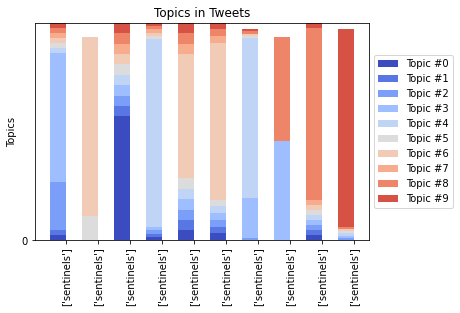

In [219]:
N = 10
ind = np.arange(N)
K = twlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Tweets')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

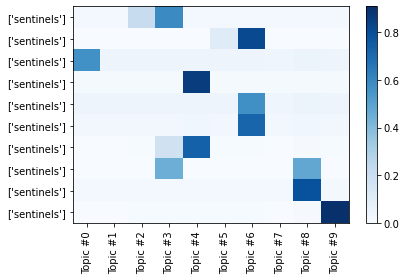

In [220]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [221]:
twlda.show_topic(1)

[('good', 0.03130574),
 ('hello', 0.02352571),
 ('shoot', 0.019957878),
 ('love', 0.015889093),
 ('want', 0.015496447),
 ('say', 0.014363919),
 ('free', 0.012381378),
 ('state', 0.01150405),
 ('like', 0.011074128),
 ('time', 0.010624788)]

In [222]:
topicsDict = {}
for topicNum in range(twlda.num_topics):
    topicWords = [w for w, p in twlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,people,good,year,like,know,love,like,thank,amp,today
1,love,hello,big,time,think,come,people,build,day,year
2,help,shoot,lose,new,need,need,say,want,like,la
3,week,love,people,yes,let,beautiful,time,live,people,work
4,thank,want,new,come,man,new,year,happen,live,thank
5,favorite,say,feel,write,trump,happy,look,need,oh,send
6,way,free,work,want,time,head,think,turn,black,like
7,na,state,end,real,woman,work,share,people,great,order
8,sa,like,support,look,amp,big,know,hour,trump,idea
9,game,time,know,know,thing,know,book,like,come,night


<Figure size 432x288 with 0 Axes>

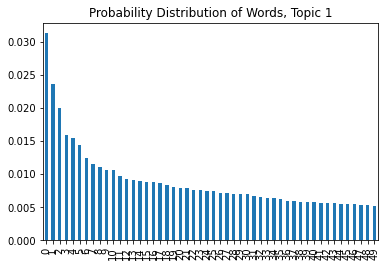

In [223]:
topic1_df = pd.DataFrame(twlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [224]:
twlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
twlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

IndexError: index 737 is out of bounds for axis 1 with size 737

In [225]:
topic11_df = pd.DataFrame(twlda1.show_topic(1, topn=50))
topic21_df = pd.DataFrame(twlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

NameError: name 'twlda1' is not defined

In [226]:
#the above 2 cells do not give errors in the other notebook with only exercises. 

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [227]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [229]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP/'

In [ ]:
import zipfile
import pandas as pd

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [ ]:
soap_df

Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [ ]:
dool = soap_df['Tokenized Texts'][9]

In [ ]:
' '.join(dool[0:1500])

In [ ]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [ ]:
import networkx as nx

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
i = 0

In [ ]:
all_texts = []

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [ ]:
all_texts[0:10]

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [ ]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [ ]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [ ]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [ ]:
from gensim.matutils import kullback_leibler

In [ ]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [ ]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [ ]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

In [ ]:
list(coha_texts.keys())[0:5]

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [ ]:
coha_genres = {}
coha_years = {}

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [ ]:
coha_genres.keys()

In [ ]:
coha_years.keys()

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [ ]:
import collections

In [ ]:
years = []
year_lens = []

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [ ]:
years[0], years[-1]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [ ]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [ ]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [ ]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [ ]:
final_corpus= []

In [ ]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [ ]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [ ]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
 ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)